# BRUN0-NET

La competizione che abbiamo scelto di affrontare richiede di creare un modello che è capace di assegnare automaticamente una valutazione ad un possibile testo che gli verrebbe sottoposto da uno studente, a partire dalle medie, fino all'ultimo anno di superiori.

La nota cruciale del sistema è che deve valutare testi di tipo argomentativo, esprimento quindi una valutazione su componenti come l'organizzazione, le prove a supporto di una tesim lo sviluppo delle idee, e altro, mantenendo però un costo ridotto per permettere anche a comunità meno abbienti di usufruirne.

Lo sviluppo del progetto è stato portato avanti utilizzando keras e bert per quanto riguarda la parte di machine learning, e varie librerie di Python per il resto. 

Il codice comunque è interamente scritto in Python.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import matplotlib.ticker as mtick
from IPython.display import display, Markdown
import re

SEED = 118
dataset_path = "./dataset"
bert_path = f"{dataset_path}/bert"

# imposta il random seed per Python, Numpy and TensorFlow (OMG AMAZING 😲)
tf.keras.utils.set_random_seed(SEED)

## Analisi del Dataset

Il dataset fornito da keras presenta circa 3000 testi argomentativi di studenti statunitensi che variano in livello da medie a superiori.
Ogni testo è stato analizzato da esperti per estrapolarne elementi del discorso comunemente trovati in testi argomentativi, in paricolare:

- `Lead`: ovvero un introduzione che che serve per catturare l'attenzione del lettore e indirizzarlo verso la tesi
- `Position`: un opinione o conclusioni tratte sull'argomento portato
- `Claim`: un'affermazione che supporti la posizione
- `Counterclaim`: a claim that refutes another claim or gives an opposing reason to the position
- `Rebuttal`: una nuova affermazione che confuta la Counterclaim
- `Evidence`: idee a supporto della Claim
- `Concluding Statement`: una frase conclusiva che ribadisce le affermazioni


Ogniuna di queste componenti è affiancata ad uno di tre giudizi che saranno le nostre label per la fase di training:

- `Ineffective`
- `Adequate`
- `Effective`


Carico il dataset in memoria e ne stampo una breve anteprima

In [35]:
dataset = pd.read_csv(f'{dataset_path}/train.csv')
dataset.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate


Controllo quanti `essey_id` compaiono nel dataset e quanti ne ho nella cartella `train`

In [36]:
unique_esseyid_dataset = dataset["essay_id"].unique()
esseyid_number = len(unique_esseyid_dataset)

real_esseyid_number = !ls {dataset_path}/train | wc -l

print(f"N Essey ID in dataset: {esseyid_number}")
print(f"N Essey ID in folder:  {real_esseyid_number[0]}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
N Essey ID in dataset: 4191
N Essey ID in folder:  4191


Vado a stampare la frequenza dei vari elementi delle colonne `discourse_type` e `discourse_effectiveness` per vedere quanto il dataset è sbilanciato

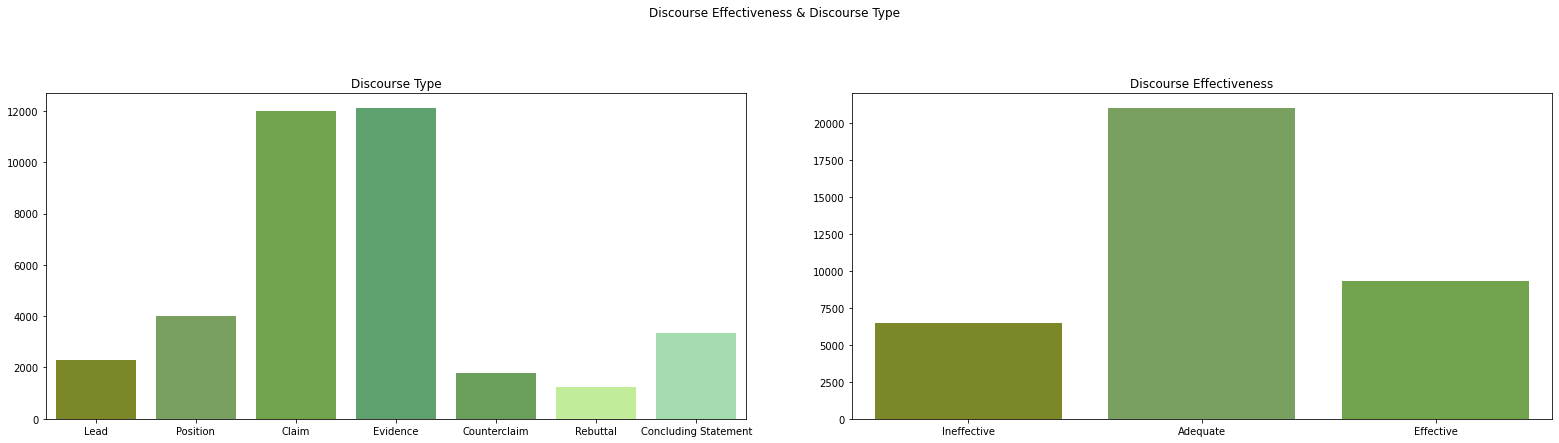

In [37]:
palette = ["xkcd:baby shit green", "xkcd:asparagus", "xkcd:nasty green", "xkcd:algae", "xkcd:fern", "xkcd:pistachio", "xkcd:hospital green"]

fig, axes = plt.subplots(1, 2, figsize=(27, 6))

# discoruse type
labels = dataset['discourse_type'].unique()
sns.countplot(
    x="discourse_type", 
    data=dataset, 
    linewidth=1.25, 
    alpha=1, 
    ax=axes[0], 
    zorder=2, 
    order=labels, 
    palette=palette
)
axes[0].set(xlabel=None, ylabel=None, title="Discourse Type")

# discoruse effectiveness
labels = ["Ineffective", "Adequate", "Effective"]
sns.countplot(
    x="discourse_effectiveness", 
    data=dataset, 
    linewidth=1.25, 
    alpha=1, 
    ax=axes[1], 
    zorder=2, 
    order=labels, 
    palette=palette
)
axes[1].set(xlabel=None, ylabel=None, title="Discourse Effectiveness")

fig.suptitle('Discourse Effectiveness & Discourse Type', y=1.08)
fig.subplots_adjust(
    wspace=0.15, 
    #left=0.1, bottom=0.1, right=0.9, top=0.9, hspace=0.4
)

plt.show()

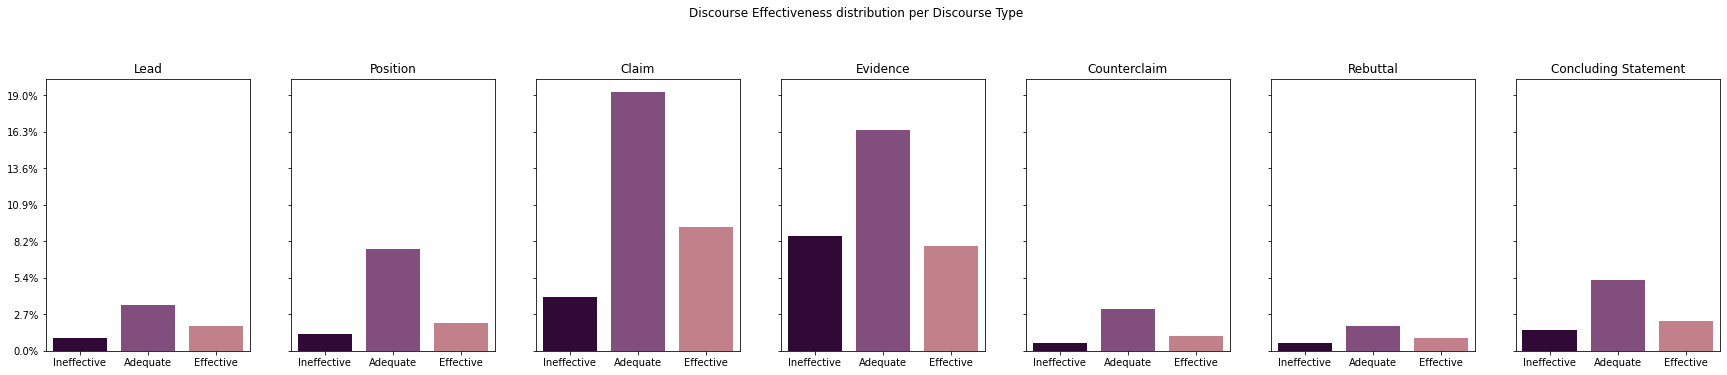

In [38]:
palette = ["xkcd:deep purple", "xkcd:light eggplant", "xkcd:ugly pink"]

discourse_types = dataset.discourse_type.unique()
discourse_id = len(dataset.discourse_id)
fig, axes = plt.subplots(1, len(discourse_types), sharex='col', sharey='row', figsize=(30, 5))
for i, discourse_type in enumerate(discourse_types):
    ax = axes[i]
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(discourse_id))

    filtered_df = dataset[dataset.discourse_type == discourse_type]
    
    sns.countplot(
        x="discourse_effectiveness", 
        data=filtered_df, 
        linewidth=1.25, 
        alpha=1, 
        ax=ax, 
        zorder=2, 
        order=labels, 
        palette=palette
    )
    ax.set(xlabel=None, ylabel=None, title=discourse_type)

fig.suptitle('Discourse Effectiveness distribution per Discourse Type', y=1.08)
plt.show()

Possiamo notare dai precedenti grafici che il dataset risulta molto **sbilanciato**:

- Nella colonna `discourse_effectiveness`, ho tantissimi elementi che appartengono alla classe `Adequate` e pochissimi per le altre 2 classi `Effective`e `Ineffective`
- Nella colonna `discourse_type`, ho tantissimi testi che appartengono alle tipologia `Evidence` e `Claim` ma estremamente pochi per tutte le altre



Vado a stampare, per ogni tipologia di testo, quanti di questi risultano `Adequate`, `Effective` e `Ineffective`.

In [75]:
# CON STOPWORDS

chars_count = []
words_count = []
punctuation_count = []

for text in dataset["discourse_text"]:
    chars = len(text)
    punctuation = len(re.findall(r"[^\w\s ']", text))
    
    chars_count.append(chars)
    words_count.append(len(re.split(r'\b\W+\b', text)))
    punctuation_count.append(punctuation)

    
dataset["discourse_chars_count"] = pd.Series(chars_count)
dataset["discourse_words_count"] = pd.Series(words_count)
dataset["discourse_punctuation_count"] = pd.Series(punctuation_count)

series_data = []
for cls in dataset["discourse_effectiveness"].unique():
    chars_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_chars_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    words_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_words_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    punctuation_count_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_punctuation_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    punctuation_percent_mean = round(punctuation_count_mean / chars_mean * 100, 3)

    # print(f'{cls}: {chars_mean} c / {words_mean} w / {punctuation_count_mean} p / {punctuation_percent_mean} p%')
    series_data.append([chars_mean, words_mean, punctuation_count_mean, punctuation_percent_mean])

# creo un nuovo dataframe per visualizzare meglio i dati
df_stat_stops = pd.DataFrame(series_data, columns=['N. Chars', 'N. Words', 'N. Punctuation', 'Punctuation Percent (%)'], index=dataset["discourse_effectiveness"].unique().tolist())

In [101]:
# SENZA STOPWORDS
import nltk


# scarica il file stopwords se non presente
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')


from nltk.corpus import stopwords

# creo la regex per individuare le stopwords
stops = set(stopwords.words("english"))
stops_regex = r""
for stop in stops:
    stops_regex += fr"\b{stop}\b|"

stops_regex = stops_regex[: -1]

no_stops = []
chars_count = []
words_count = []
punctuation_count = []

for text in dataset["discourse_text"]:
    # da forma compatta a forma estesa: i'm -> i am
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    
    # rimozione delle stopwords
    nostops_text = re.sub(stops_regex, '', text)

    chars = len(nostops_text)
    words = len(re.split(r'\b\W+\b', nostops_text))
    punctuation = len(re.findall(r"[^\w\s ']", nostops_text))
    
    no_stops.append(nostops_text)
    chars_count.append(chars)
    words_count.append(words)
    punctuation_count.append(punctuation)

dataset["discourse_nostops"] = pd.Series(no_stops)
dataset["discourse_chars_count"] = pd.Series(chars_count)
dataset["discourse_words_count"] = pd.Series(words_count)
dataset["discourse_punctuation_count"] = pd.Series(punctuation_count)

series_data = []
for cls in dataset["discourse_effectiveness"].unique():
    chars_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_chars_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    words_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_words_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    punctuation_count_mean = round(dataset[dataset.discourse_effectiveness==cls]["discourse_punctuation_count"].sum()/len(dataset[dataset.discourse_effectiveness==cls]))
    punctuation_percent_mean = round(punctuation_count_mean / chars_mean * 100, 3)

    series_data.append([chars_mean, words_mean, punctuation_count_mean, punctuation_percent_mean])

# creo un nuovo dataframe per visualizzare meglio i dati
df_stat_nostops = pd.DataFrame(series_data, columns=['N. Chars', 'N. Words', 'N. Punctuation', 'Punctuation Percent (%)'], index=dataset["discourse_effectiveness"].unique().tolist())

In [98]:
display(Markdown("### Statistiche CON Stopwrods"))
display(df_stat_stops.head())

display(Markdown("### Statistiche SENZA Stopwrods"))
display(df_stat_nostops.head())

display(Markdown("### Differenza Senza - Con"))
display(df_stat_nostops - df_stat_stops)

### Statistiche CON Stopwrods

,N. Chars,N. Words,N. Punctuation,Punctuation Percent (%)
Adequate,193,36,3,1.554
Ineffective,266,49,4,1.504
Effective,364,64,6,1.648


### Statistiche SENZA Stopwrods

,N. Chars,N. Words,N. Punctuation,Punctuation Percent (%)
Adequate,144,19,3,2.083
Ineffective,199,26,4,2.010
Effective,276,34,6,2.174


### Differenza Senza - Con

,N. Chars,N. Words,N. Punctuation,Punctuation Percent (%)
Adequate,-49,-17,0,0.529
Ineffective,-67,-23,0,0.506
Effective,-88,-30,0,0.526


## PreProcessing Dataset

Inizio la preparazione del staset andando a convertire le classi della colonna `discourse_effectiveness` in valori univoci (`int`) per poterli poi passare al modello con più semplicità.

In [19]:
def words_to_indices(words: pd.Series) -> list:
    """
        Questa funzione va ad assegnare un ID unico (parte da 0) ad ogni elemento della serice (colonna)
        che gli viene passato.

        E.g.
            input:  pd.Series(['a', 'b', 'a', 'c', 'd', 'c'])
            output: [(0, 'a'), (1, 'b'), (2, 'c'), (3, 'd')]
    """

    enumeration = enumerate(words.unique()) # prende ogni elemento 1 sola volta
                                            # funzione unique() fa si che ad ogni run l'ordine della parole sia lo stesso
                                            # a differenza di set()
    
    return list(enumeration)


In [20]:
# assegna degli indici univoci alle classi della colonna discourse_effectiveness
effectiveness_label_index = words_to_indices(dataset["discourse_effectiveness"])

# creo le due nuove colonne
dataset["effectiveness_label"] = dataset['discourse_effectiveness']

# rimpiazzo gli elementi dalle nuove colonne con quelli corretti (gli indici numerici)
for new_value, old_value in effectiveness_label_index:
    dataset["effectiveness_label"].replace(old_value, new_value, inplace=True)

Definisco la configurazione base per il modello di Embedding **BERT** ed altri parametri per il dataset

In [21]:
# Bert Configuration
AUTO = tf.data.experimental.AUTOTUNE
MAX_LEN = 256
EPOCHS = 3
BATCH_SIZE = 12

In [22]:
# Definizione del modello di encoding con Bert
def bert_encode(texts, tokenizer, max_len=MAX_LEN):
    input_ids      = []
    token_type_ids = []
    attention_mask = []
    
    for text in texts:
        token = tokenizer(
            text, 
            max_length=max_len, 
            truncation=True, 
            padding='max_length',
            add_special_tokens=True
            )
        input_ids.append(token['input_ids'])
        token_type_ids.append(token['token_type_ids'])
        attention_mask.append(token['attention_mask'])
    
    return np.array(input_ids), np.array(token_type_ids), np.array(attention_mask)

In [23]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

In [24]:
sep = tokenizer.sep_token
sep

'[SEP]'

Vado ad aggiungre una nuova colonna al dataset dove andrò a concatenare il dipo del discorso ed il discorso stesso (unisco le colonne `discourse_type` e `discourse_text`) tramite un carattere **separatore** che BERT sarà in grado di riconoscere.

In [25]:
# genera una nuova colonna includendo 'discourse_type' all'interno del testo da analizzare
dataset['inputs'] = dataset.discourse_type + sep + dataset.discourse_text
dataset['inputs_nostops'] = dataset.discourse_type + sep + dataset.discourse_nostops
dataset.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,discourse_chars_count,discourse_words_count,discourse_punctuation_count,discourse_nostops,effectiveness_label,inputs,inputs_nostops
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,220,28,6,"Hi, Isaac, going writing face Mars...",0,"Lead[SEP]Hi, i'm Isaac, i'm going to be writin...","Lead[SEP]Hi, Isaac, going writing f..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,147,21,3,"On perspective, I think face natural land...",0,"Position[SEP]On my perspective, I think that t...","Position[SEP]On perspective, I think face ..."
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,67,9,0,I think face natural landform life Ma...,0,Claim[SEP]I think that the face is a natural l...,Claim[SEP]I think face natural landform ...
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,266,36,11,"If life Mars, would know . The reason I t...",0,"Evidence[SEP]If life was on Mars, we would kno...","Evidence[SEP]If life Mars, would know . Th..."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,64,8,1,People thought face formed alieans thoug...,0,Counterclaim[SEP]People thought that the face ...,Counterclaim[SEP]People thought face formed...


Suddivido il dataset in una parte di **training** e una parte di **valdation**

Vado ad applicare BERT all'input per codificarlo in modo tale da essere passato al modello

In [26]:
from sklearn.model_selection import GroupShuffleSplit


X = dataset[["essay_id", "inputs", "inputs_nostops"]]
y= dataset["effectiveness_label"]

gs = GroupShuffleSplit(n_splits=3, test_size=.2, random_state=420)  # fa si che tutti gli elementi di un testo rimangano nello stesso set
train_ix, test_ix = next(gs.split(X, y, groups=X.essay_id))

X_train = X.loc[train_ix]
y_train = y.loc[train_ix]

X_test = X.loc[test_ix]
y_test = y.loc[test_ix]

# CON STOPWORDS
x_train = X_train["inputs"]
x_test = X_test["inputs"]

# SENZA STOPWORDS
x_train_nostops = X_train["inputs_nostops"]
x_test_nostops = X_test["inputs_nostops"]


In [27]:
print(x_train[0])
print(x_train_nostops[0])
print(y_train[0])

Lead[SEP]Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform. 
Lead[SEP]Hi,    Isaac,    going   writing    face  Mars   natural landform     life  Mars  made . The story    NASA took  picture  Mars   face  seen   planet. NASA    know   landform  created  life  Mars,       natural landform. 
0


In [28]:
# CON STOPWORDS
x_train = bert_encode(x_train.astype(str), tokenizer)
x_test = bert_encode(x_test.astype(str), tokenizer)

y_train = y_train.values
y_test = y_test.values

# SENZA STOPWORDS
x_train_nostops = bert_encode(x_train_nostops.astype(str), tokenizer)
x_test_nostops = bert_encode(x_test_nostops.astype(str), tokenizer)

y_train_nostops = y_train
y_test_nostops = y_test

Vado a creare i dataset finali di training e validation tramite le API di tensorflow

## Model Selection

In [29]:
import json
from tensorflow import keras
from keras.layers import Dense, LSTM, Dropout, Flatten, Input, MaxPooling1D, Conv1D
from keras.models import Model
from transformers import TFBertModel
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint

Scrivo una funzione che mi aiuta ad allenare e testare i varo modelli che creerò per poter scegliere il migliore

In [32]:
def train_and_plot(model_builder: callable, model_version: str, batch_size=BATCH_SIZE, epochs=30, patience=10, steps_per_epoch=100, remove_stopwards=False):
    # pulisce la sessione di Keras permettendomi di caricare in memoria modelli in successione
    K.clear_session()
    # imposto il seed al valore iniziale per far si che tutti gli allenamenti risultino uguali
    tf.keras.utils.set_random_seed(SEED)
    
    model = model_builder()
    model.summary()

    keras.utils.plot_model(model, f"./BRUN0-Net-{model_version}.png") # salva la foto del modello

    # --- SCELTA STOPWORDS ---
    if remove_stopwards:
        train = x_train_nostops
        test = x_test_nostops
        print('no stops')
    else:
        train = x_train
        test = x_test
        print('stop')
    
    # --- DATASET ---
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(batch_size)
        .prefetch(AUTO)
    )

    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices((test, y_test))
        .batch(batch_size)
        .cache()
        .prefetch(AUTO)
    )

    # --- CALLBACKS ---
    model_filepath = f'BRUN0-Net-{model_version}.h5'

    # Early Stopping:  ferma la fase di trainign quando la val_los non migliora per {patience} epoche
    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=patience
    )

    # Salva il modello su file quando migliora la val_los
    save_best = ModelCheckpoint(
        model_filepath, 
        monitor='val_loss', 
        save_best_only=True, 
        mode='min', 
        verbose=1
    ) 

    # --- TRAINING ---
    history = model.fit(
        train_dataset,
        validation_data=test_dataset, 
        epochs=epochs, 
        verbose=True, 
        steps_per_epoch=steps_per_epoch,
        callbacks=[es, save_best]
    )

    # --- HISTORY ---
    history_dict = history.history
    json.dump(history_dict, open(f'./history_save-{model_version}.bk', 'w'))

    # utile per quando serve ricaricare il file history in memoria
    # history_dict = json.load(open('./history_save.bk', 'r'))

    # --- GRAFICI ALLENAMENTO ---
    # accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [33]:
# TODO: i modelli vanno riallenati TUTTI !!!

### Primo Allenamento

Spieghino del problema che abbiamo avuto con ADAM

#### Model Alpha $\alpha$

Tramite le API di tesnorflow e Keras e sfruttando il paradigma (??) Funzionale, vado a definire il modello.
Utilizzo il paradigma funzionale perchè è l'unico che permette di avere molteplici input e per ognuno la possibilità di passarlo ad un diverso layer.

In [31]:
def alpha_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(256, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)

    flatten = Flatten()(max_pool_1)
    
    # --- CLASSIFICATORE ---
    net  = Dropout(.1, name="dropout_1")(flatten)
    net  = Dense(124, activation='relu', name="dense_1")(net)
    net  = Dropout(.1, name="dropout_2")(net)
    net  = Dense(32, activation='relu', name="dense_2")(net)

    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model


In [ ]:
train_and_plot(alpha_model_builder, 'alpha')

#### Model Beta $\beta$

In [19]:
def beta_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(512, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(256, 5, activation='relu', name="conv_2")(conv_1)
    conv_3      = Conv1D(128, 5, activation='relu', name="conv_3")(conv_2)
    conv_4      = Conv1D(64, 5, activation='relu', name="conv_4")(conv_3)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_4)

    flatten = Flatten()(max_pool_1)
    
    # --- CLASSIFICATORE ---
    net  = Dropout(.2, name="dropout_1")(flatten)
    net  = Dense(126, activation='relu', name="dense_1")(net)
    net  = Dropout(.2, name="dropout_2")(net)
    net  = Dense(64, activation='relu', name="dense_2")(net)
    net  = Dropout(.1, name="dropout_3")(net)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dropout(.1, name="dropout_4")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)

    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

In [ ]:
train_and_plot(beta_model_builder, 'beta', batch_size=8)

#### Model Gamma $\gamma$

In [14]:
def gamma_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    flatten = Flatten()(sequence_output)
    
    # --- CLASSIFICATORE ---
    # net  = Dense(126, activation='relu', name="dense_1")(flatten)
    net  = Dense(64, activation='relu', name="dense_2")(flatten)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)

    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

In [ ]:
train_and_plot(gamma_model_builder, 'gamma', batch_size=8)

#### Model Delta $\delta$

In [14]:
def delta_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # --- MIDDEL LAYER ---
    lstm_1 = LSTM(8, return_sequences=True, name="lstm_1")(sequence_output)
    lstm_2 = LSTM(4, name="lstm_2")(lstm_1)

    # --- OUTPUT ---
    drop_out = Dropout(.1)(lstm_2)
    out = Dense(3, activation='softmax', name="output")(drop_out)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

2022-06-22 14:44:38.921918: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:44:38.927005: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:44:38.927238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 14:44:38.927995: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_for_masked_lm (TFBertF  TFMaskedLMOutput(lo  108340804  ['input_ids[0][0]',              
 orMaskedLM)                    ss=None, logits=(No               'attention_mask[0][0]',     

2022-06-22 14:44:51.511705: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


100/100 [==============================] - ETA: 0s - loss: 1.0056 - accuracy: 0.5775
Epoch 1: val_loss improved from inf to 0.99391, saving model to BRUN0-Net-delta.h5
100/100 [==============================] - 140s 1s/step - loss: 1.0056 - accuracy: 0.5775 - val_loss: 0.9939 - val_accuracy: 0.5632
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.9672 - accuracy: 0.5908
Epoch 2: val_loss improved from 0.99391 to 0.98523, saving model to BRUN0-Net-delta.h5
100/100 [==============================] - 131s 1s/step - loss: 0.9672 - accuracy: 0.5908 - val_loss: 0.9852 - val_accuracy: 0.5632
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 1.0011 - accuracy: 0.5450
Epoch 3: val_loss improved from 0.98523 to 0.98357, saving model to BRUN0-Net-delta.h5
100/100 [==============================] - 130s 1s/step - loss: 1.0011 - accuracy: 0.5450 - val_loss: 0.9836 - val_accuracy: 0.5632
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 

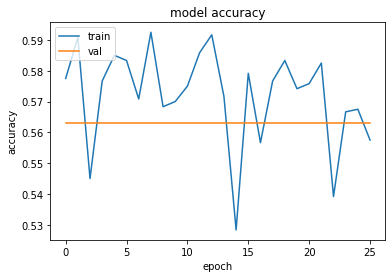

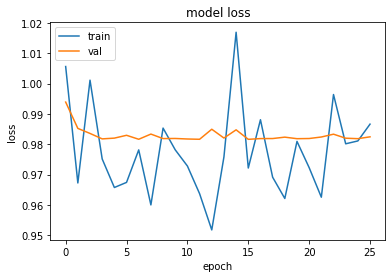

In [15]:
train_and_plot(delta_model_builder, 'delta')

#### Model Epsilon $\epsilon$

In [16]:
def epsilon_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(128, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)
    
    lstm_1 = LSTM(4, return_sequences=True, name="lstm_1")(max_pool)
    lstm_2 = LSTM(2, name="lstm_2")(lstm_1)

    # --- OUTPUT ---
    flatten = Flatten()(lstm_2)
    out = Dense(3, activation='softmax', name="output")(flatten)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer="adam", loss ="sparse_categorical_crossentropy", metrics = ["accuracy"] )
    
    return model

All model checkpoint layers were used when initializing TFBertForMaskedLM.

All the layers of TFBertForMaskedLM were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForMaskedLM for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_for_masked_lm (TFBertF  TFMaskedLMOutput(lo  108340804  ['input_ids[0][0]',              
 orMaskedLM)                    ss=None, logits=(No               'attention_mask[0][0]',     

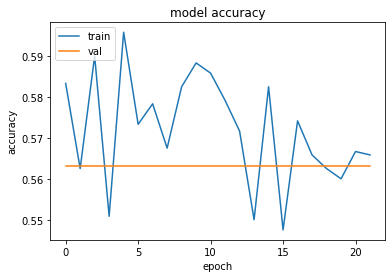

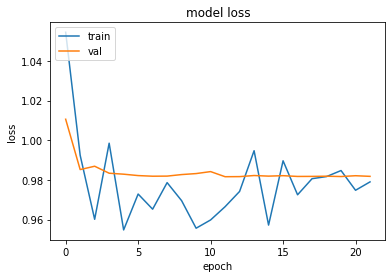

In [17]:
train_and_plot(epsilon_model_builder, 'epsilon')

### Secondo Allenamento

In [22]:
from keras.optimizers import Adam

#### Model Alpha Plus $\alpha^+$

In [ ]:
def alphaplus_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(256, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)

    flatten = Flatten()(max_pool_1)
    
    # --- CLASSIFICATORE ---
    net  = Dropout(.1, name="dropout_1")(flatten)
    net  = Dense(124, activation='relu', name="dense_1")(net)
    net  = Dropout(.1, name="dropout_2")(net)
    net  = Dense(32, activation='relu', name="dense_2")(net)

    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model


In [ ]:
train_and_plot(alphaplus_model_builder, 'alpha_plus')

#### Model Beta Plus $\beta^+$

In [14]:
def betaplus_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]
    
    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(512, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(256, 5, activation='relu', name="conv_2")(conv_1)
    conv_3      = Conv1D(128, 5, activation='relu', name="conv_3")(conv_2)
    conv_4      = Conv1D(64, 5, activation='relu', name="conv_4")(conv_3)
    max_pool_1  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_4)

    flatten = Flatten()(max_pool_1)
    
    # --- CLASSIFIER ---
    net  = Dropout(.2, name="dropout_1")(flatten)
    net  = Dense(126, activation='relu', name="dense_1")(net)
    net  = Dropout(.2, name="dropout_2")(net)
    net  = Dense(64, activation='relu', name="dense_2")(net)
    net  = Dropout(.1, name="dropout_3")(net)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dropout(.1, name="dropout_4")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)
    
    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model

2022-06-23 09:09:23.592509: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further traini

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

2022-06-23 09:09:34.203506: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


100/100 [==============================] - ETA: 0s - loss: 1.0529 - accuracy: 0.5417
Epoch 1: val_loss improved from inf to 0.96612, saving model to BRUN0-Net-beta_plus.h5
100/100 [==============================] - 126s 1s/step - loss: 1.0529 - accuracy: 0.5417 - val_loss: 0.9661 - val_accuracy: 0.5860
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 1.0196 - accuracy: 0.5417
Epoch 2: val_loss did not improve from 0.96612
100/100 [==============================] - 115s 1s/step - loss: 1.0196 - accuracy: 0.5417 - val_loss: 0.9771 - val_accuracy: 0.5860
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.9904 - accuracy: 0.5817
Epoch 3: val_loss did not improve from 0.96612
100/100 [==============================] - 115s 1s/step - loss: 0.9904 - accuracy: 0.5817 - val_loss: 0.9841 - val_accuracy: 0.5860
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 0.9808 - accuracy: 0.5842
Epoch 4: val_loss improved from 0.96612 to 0.96417

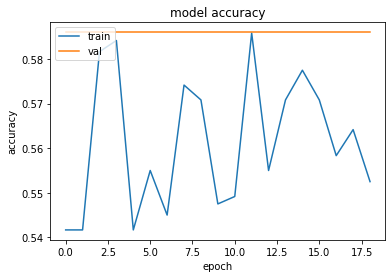

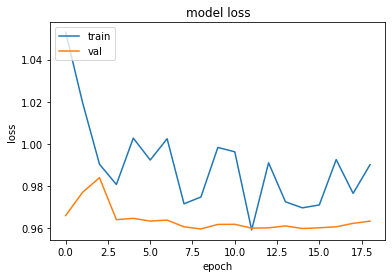

In [15]:
train_and_plot(betaplus_model_builder, 'beta_plus')

#### Model Gamma Plus $\gamma^+$

In [ ]:
def gammaplus_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    flatten = Flatten()(sequence_output)
    
    # --- CLASSIFIER ---
    # net  = Dense(126, activation='relu', name="dense_1")(flatten)
    net  = Dense(64, activation='relu', name="dense_2")(flatten)
    net  = Dense(32, activation='relu', name="dense_3")(net)
    net  = Dense(16, activation='relu', name="dense_4")(net)

    # --- OUTPUT ---
    out = Dense(3, activation='softmax', name="output")(net)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model

In [ ]:
train_and_plot(gammaplus_model_builder, 'gamma_plus')

#### Model Delta Plus $\delta^+$

In [ ]:
def deltaplus_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # --- MIDDEL LAYER ---
    lstm_1 = LSTM(8, return_sequences=True, name="lstm_1")(sequence_output)
    lstm_2 = LSTM(4, name="lstm_2")(lstm_1)

    # --- OUTPUT ---
    drop_out = Dropout(.1)(lstm_2)
    out = Dense(3, activation='softmax', name="output")(drop_out)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model

In [ ]:
train_and_plot(deltaplus_model_builder, 'delta_plus')

#### Model Epsilon Plus $\epsilon^+$

In [16]:
def epsilonplus_model_builder(max_len=MAX_LEN):  
    # --- INPUTS ---  
    input_ids       = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
    token_type_ids  = Input(shape=(max_len,), dtype=tf.int32, name="token_type_ids")
    attention_mask  = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

    # --- BERT WORLD EMBEDDING ---
    bert_model = TFBertModel.from_pretrained("bert-base-cased")
    sequence_output = bert_model(input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)[0]

    # --- MIDDEL LAYER ---
    conv_1      = Conv1D(128, 5, activation='relu', name="conv_1")(sequence_output)
    conv_2      = Conv1D(64, 5, activation='relu', name="conv_2")(conv_1)
    max_pool  = MaxPooling1D(pool_size=3, name="maxpooling")(conv_2)
    
    lstm_1 = LSTM(4, return_sequences=True, name="lstm_1")(max_pool)
    lstm_2 = LSTM(2, name="lstm_2")(lstm_1)

    # --- OUTPUT ---
    flatten = Flatten()(lstm_2)
    out = Dense(3, activation='softmax', name="output")(flatten)
    
    model = Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=out)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"] )
    
    return model

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]',     

Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


100/100 [==============================] - ETA: 0s - loss: 1.0816 - accuracy: 0.4733
Epoch 1: val_loss improved from inf to 1.04429, saving model to BRUN0-Net-epsilon_plus.h5
100/100 [==============================] - 124s 1s/step - loss: 1.0816 - accuracy: 0.4733 - val_loss: 1.0443 - val_accuracy: 0.5860
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 1.0271 - accuracy: 0.5583
Epoch 2: val_loss improved from 1.04429 to 1.00368, saving model to BRUN0-Net-epsilon_plus.h5
100/100 [==============================] - 115s 1s/step - loss: 1.0271 - accuracy: 0.5583 - val_loss: 1.0037 - val_accuracy: 0.5860
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 1.0066 - accuracy: 0.5642
Epoch 3: val_loss improved from 1.00368 to 0.98184, saving model to BRUN0-Net-epsilon_plus.h5
100/100 [==============================] - 116s 1s/step - loss: 1.0066 - accuracy: 0.5642 - val_loss: 0.9818 - val_accuracy: 0.5860
Epoch 4/30
100/100 [=============================

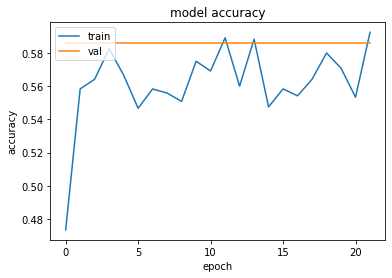

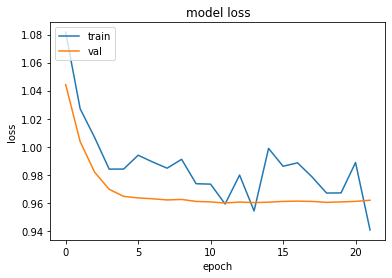

In [17]:
train_and_plot(epsilonplus_model_builder, 'epsilon_plus')